# Transfer Learning & Experiments

Experiment by creating a few models:
- `m0`: Use feature extraction transfer learning on `10%` of the training data 
- `m1`: Use feature extraction transfer learning on `1%` of the training data
  - **with data augmentation**
- `m2`: Use feature extraction transfer learning on `10%` of the training data
  - **with data augmentation**
  - save the results to a checkpoint
- `m3`: Fine-tune the m2 checkpoint on `10%` of the training data
  - **with data augmentation**
- `m4`: Fine-tune the m2 checkpoint on `100%` of the training data
  - **with data augmentation**

## Notebook Goals
- build at least 4 models, running at least 4 experiments on the data (see above)
- Compare the impact on model performance of 2 variables:
  - amount of training data
  - data augmentation
- Build a fn to augment-and-plot random images, comparing augmented-to-regular (_for visual review_)
 
## Imports

In [1]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

In [2]:
## Download Helper Functions
# Download helper_functions.py script
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-06-26 23:22:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.009s  

2024-06-26 23:22:25 (1.05 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



## Get Data

In [3]:
# 
# 10% set of data based on the food101 dataset
# 

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")


# 
# 1%
# 
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# unzip_data("10_food_classes_1_percent.zip")

--2024-06-26 23:22:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.32.123, 142.251.35.187, 142.251.40.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.32.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   674KB/s    in 3m 18s  

2024-06-26 23:25:45 (659 KB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



### Preview the 1% data
- `7` images per class in training
- `250` images per class in testing

In [4]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

## Data & Var Prep for multi-model experimentation

In [5]:
# 
# 10% of the data
# 
data_dir_path_10p = "10_food_classes_10_percent/"
train_dir_path_10p = data_dir_path_10p + "train/"
test_dir_path_10p = data_dir_path_10p + "test/"

# 
# 1% of the data
# 
data_dir_path_1p = "10_food_classes_1_percent/"
train_dir_path_1p = data_dir_path_1p + "train/"
test_dir_path_1p = data_dir_path_1p + "test/"

IMG_OUTPUT_SIZE = (224, 224)
labelMode = "categorical"
# batchSize = 32
batchSize = 16

## Model I: train-on-10%
### Split Data: Test & Train

In [6]:
train_data_10p = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_path_10p,
                                                                            image_size=IMG_OUTPUT_SIZE,
                                                                            label_mode=labelMode,
                                                                            batch_size=batchSize)
test_data_10p = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_path_10p,
                                                                           image_size=IMG_OUTPUT_SIZE,
                                                                           label_mode=labelMode)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# 
# inspect training data var
# 
train_data_10p

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10p.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# 
# see ALL methods available on the new vars
# 

# dir(train_data_10p)

In [10]:
# 
# preview some data using the "take" method
# 

# for images, labels in train_data_10p.take(1):
#   print(images,labels)

### Build, Compile & Fit

In [11]:
modelName = 'm0'
lessValidationDataCount = int(0.25 * len(test_data_10p))
csv_logger = CSVLogger(f'{modelName}-log.csv', append=True, separator=';')

# 
# pre-trained model
# 
# 1. Create base model with tf.keras.applications
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 
# custom layer(s)
# 
# 3. Create inputLayer into the base model
inputLayer = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")


# "4" If using ResNet50V2, add this to speed up convergence by rescaling inputs
# NOT for EfficientNetV2
# appliedModel = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputLayer)


# 5. Apply the inputLayer to the base_model (note: using tf.keras.applications, EfficientNetV2 inputLayer don't have to be normalized)
appliedModel = base_model(inputLayer)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {appliedModel.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
appliedModel = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(appliedModel)
print(f"After GlobalAveragePooling2D(): {appliedModel.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(appliedModel)

# 8. Combine the inputLayer with the outputs into a model
m0 = tf.keras.Model(inputLayer, outputs)

# 9. Compile the model
m0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
m0History = m0.fit(train_data_10p,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10p),
                                 validation_data=test_data_10p,
                                 # Go through LESS of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=lessValidationDataCount,
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10p_feature_extract"), csv_logger])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10p_feature_extract/20240626-232551
Epoch 1/5
47/47 [==============================] - 52s 998ms/step - loss: 1.6840 - accuracy: 0.4880 - val_loss: 1.0867 - val_accuracy: 0.7467
Epoch 2/5
47/47 [==============================] - 38s 785ms/step - loss: 0.9150 - accuracy: 0.7840 - val_loss: 0.7479 - val_accuracy: 0.8257
Epoch 3/5
47/47 [==============================] - 38s 805ms/step - loss: 0.6739 - accuracy: 0.8387 - val_loss: 0.6425 - val_accuracy: 0.8355
Epoch 4/5
47/47 [==============================] - 34s 727ms/step - loss: 0.5514 - accuracy: 0.8707 - val_loss: 0.5531 - val_accuracy: 0.8586
Epoch 5/5
47/47 [==============================] - 36s 761ms/step - loss: 0.4799 - accuracy: 0.8933 - val_loss: 0.5279 - val_accuracy: 0.8454


### Inspect Model
There is a `base_model` which is JUST the "starting place".  
There is also the `m0`, which is the transfer-learned model including our data.  


#### Summary

In [12]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [13]:
m0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

### Visualize Loss & Accuracy Curves

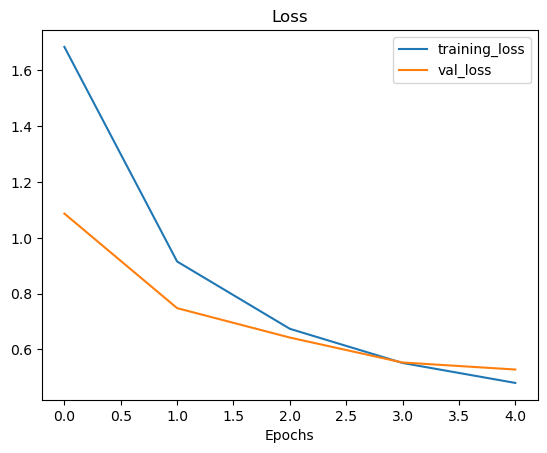

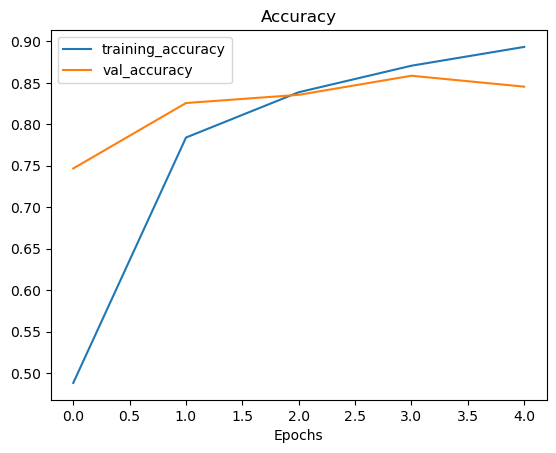

In [14]:
plot_loss_curves(m0History)

## Model II: train-on-1%-with-aug
### Split Data: Test & Train

In [15]:
train_data_1p = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_path_1p,
                                                                            image_size=IMG_OUTPUT_SIZE,
                                                                            label_mode=labelMode,
                                                                            batch_size=batchSize)
test_data_1p = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_path_1p,
                                                                           image_size=IMG_OUTPUT_SIZE,
                                                                           label_mode=labelMode)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Augment The Training Data
Using a `Sequential` keras model, a composed augmentation layer will be made. The augmentation layer will be made of several "inner" layers. The "inner" layers are the layers that will "augment" the data, as described by each layer:

In [16]:
augmentationLayer = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")


# # NOTE: 
# Previous versions of TensorFlow (e.g. 2.4 and below) used 
# tensorflow.keras.layers.experimental.processing:

# augmentationLayer = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

### Visualize Some Original & Augmented Images

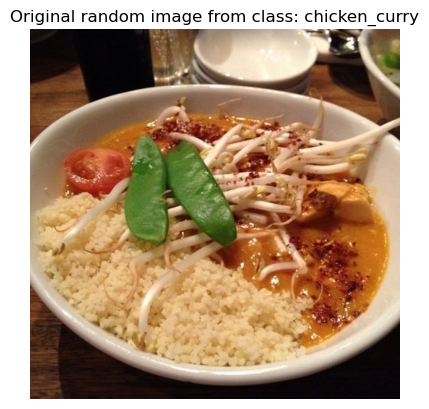

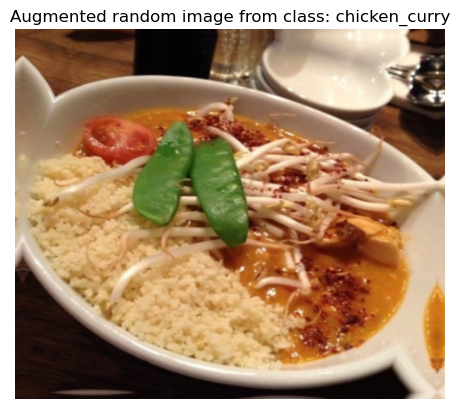

In [43]:
target_class = random.choice(train_data_1p.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Reshape, Augment, and ReNormalize
imgWithNewShape = tf.expand_dims(img, axis=0)
augmented_img = augmentationLayer(imgWithNewShape) # data augmentation model requires shape (None, height, width, 3)
normalizedAugmentedImg = tf.squeeze(augmented_img)/255. # requires normalization after augmentation

plt.figure()
plt.imshow(normalizedAugmentedImg)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Build, Compile, Fit

In [44]:
# RE-Using inputLayer var from above

# Add in data augmentation Sequential model as a layer
applied1pAugModel = augmentationLayer(inputLayer)

# Give base_model inputLayer (after augmentation) and don't train it
applied1pAugModel = base_model(applied1pAugModel, training=False)

# Pool output features of base model
applied1pAugModel = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(applied1pAugModel)

# Put a dense layer on as the output
applied1pAugOutput = layers.Dense(10, activation="softmax", name="output_layer")(applied1pAugModel)

# Make a model with "inputs" and "outputs"
m1 = keras.Model(inputLayer, applied1pAugOutput)

# Compile the model
m1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1p = m1.fit(train_data_1p,
                    epochs=5,
                    steps_per_epoch=len(train_data_1p),
                    validation_data=test_data_1p,
                    validation_steps=int(0.25* len(test_data_1p)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1p_data_aug")])

Saving TensorBoard log files to: transfer_learning/1p_data_aug/20240627-112814
Epoch 1/5
5/5 [==============================] - 28s 5s/step - loss: 2.2937 - accuracy: 0.1143 - val_loss: 2.1303 - val_accuracy: 0.2188
Epoch 2/5
5/5 [==============================] - 20s 5s/step - loss: 2.0026 - accuracy: 0.3286 - val_loss: 1.9705 - val_accuracy: 0.3372
Epoch 3/5
5/5 [==============================] - 18s 4s/step - loss: 1.7992 - accuracy: 0.5286 - val_loss: 1.8296 - val_accuracy: 0.4474
Epoch 4/5
5/5 [==============================] - 18s 4s/step - loss: 1.5877 - accuracy: 0.6429 - val_loss: 1.6961 - val_accuracy: 0.5263
Epoch 5/5
5/5 [==============================] - 19s 5s/step - loss: 1.3815 - accuracy: 0.8143 - val_loss: 1.6008 - val_accuracy: 0.5444


### Inspect Model
#### Summary

In [45]:
m1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [46]:
m1.evaluate(test_data_1p)

79/79 [==============================] - 67s 847ms/step - loss: 1.6071 - accuracy: 0.5484


[1.6070656776428223, 0.5483999848365784]

### Visualize Loss & Accuracy Curves

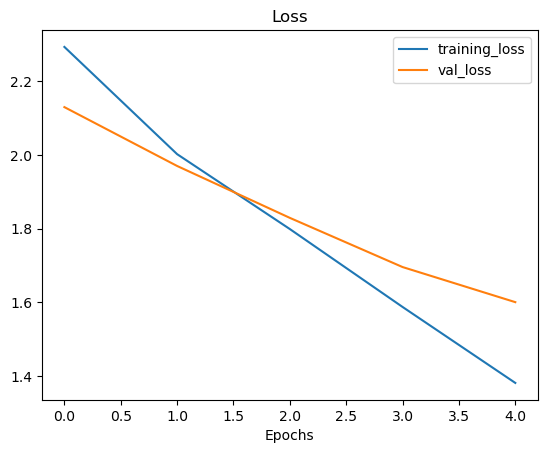

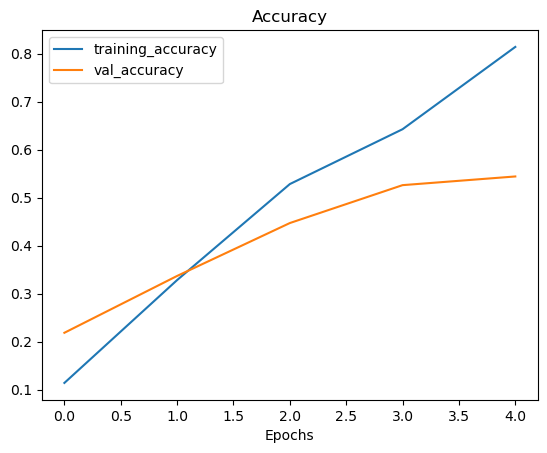

In [48]:
plot_loss_curves(history_1p)

## Model III: train-on-10%-with-aug
This uses a few of the same variables set above used in `m0`, as that model also used `10%` of the food101 dataset.  

### Build, Compile

In [22]:
appliedM310pAug = augmentationLayer(inputLayer) # augment our training images

# training=False: https://keras.io/guides/transfer_learning/#build-a-model
# pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated

appliedM310pAug = base_model(appliedM310pAug, training=False)


appliedM310pAug = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(appliedM310pAug)
appliedM3Outputs = layers.Dense(10, activation="softmax", name="output_layer")(appliedM310pAug)
m3 = tf.keras.Model(inputLayer, appliedM3Outputs)

# Compile
m3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

### Create New Callback: ModelCheckpoint
[save the model OR model weights at a given frequency](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [23]:
savedCheckpointPath = "m3_10p_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=savedCheckpointPath,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit

In [24]:
m3History = m3.fit(train_data_10p,
                                          epochs=5,
                                          validation_data=test_data_10p,
                                          validation_steps=int(0.25 * len(test_data_10p)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10p_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10p_data_aug/20240626-233201
Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 1.9024 - accuracy: 0.3707
Epoch 1: val_loss improved from inf to 1.26410, saving model to m3_10p_checkpoints_weights/checkpoint.ckpt
47/47 [==============================] - 53s 1s/step - loss: 1.9024 - accuracy: 0.3707 - val_loss: 1.2641 - val_accuracy: 0.7007
Epoch 2/5
47/47 [==============================] - ETA: 0s - loss: 1.2041 - accuracy: 0.6960
Epoch 2: val_loss improved from 1.26410 to 0.90469, saving model to m3_10p_checkpoints_weights/checkpoint.ckpt
47/47 [==============================] - 42s 846ms/step - loss: 1.2041 - accuracy: 0.6960 - val_loss: 0.9047 - val_accuracy: 0.7582
Epoch 3/5
47/47 [==============================] - ETA: 0s - loss: 0.9459 - accuracy: 0.7613
Epoch 3: val_loss improved from 0.90469 to 0.72246, saving model to m3_10p_checkpoints_weights/checkpoint.ckpt
47/47 [==============================] - 38s 812ms/

### Summarize, Visualize, Inspect

In [26]:
m3_10p_aug_evaluated = m3.evaluate(test_data_10p)
m3_10p_aug_evaluated

79/79 [==============================] - 65s 814ms/step - loss: 0.5727 - accuracy: 0.8360


[0.5727317929267883, 0.8360000252723694]

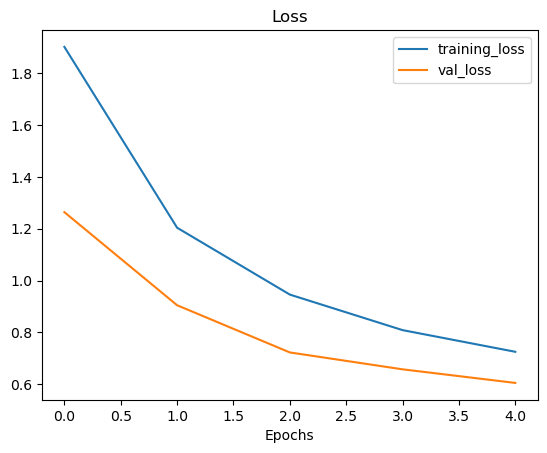

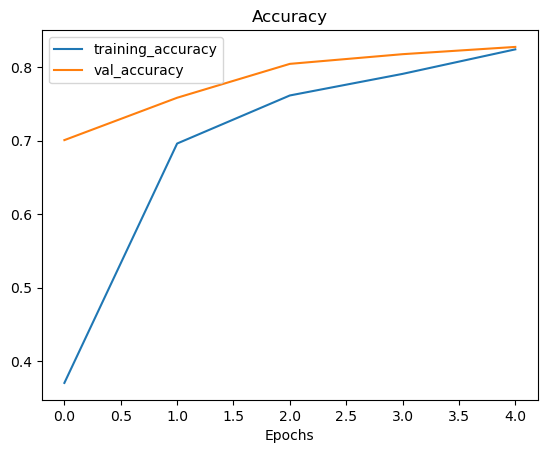

In [27]:
plot_loss_curves(m3History)

In [28]:
m3.layers

In [33]:
for layer_number, layer in enumerate(m3.layers):
  print(f"Layer NUMBER: {layer_number} \t| NAME: {layer.name} \t| TYPE: {layer} \t| Trainable? {layer.trainable}")

Layer NUMBER: 0 	| NAME: input_layer 	| TYPE: <keras.src.engine.input_layer.InputLayer object at 0xffff29d7fe90> 	| Trainable? True
Layer NUMBER: 1 	| NAME: data_augmentation 	| TYPE: <keras.src.engine.sequential.Sequential object at 0xfffef453a4d0> 	| Trainable? True
Layer NUMBER: 2 	| NAME: efficientnetv2-b0 	| TYPE: <keras.src.engine.functional.Functional object at 0xffff282b67d0> 	| Trainable? False
Layer NUMBER: 3 	| NAME: global_average_pooling_layer 	| TYPE: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0xfffed239b410> 	| Trainable? True
Layer NUMBER: 4 	| NAME: output_layer 	| TYPE: <keras.src.layers.core.dense.Dense object at 0xfffed21e1b90> 	| Trainable? True


In [34]:
m3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281